# Multi-Template matching 
## Tutorial 2 : template "augmentation"

In this tutorial we will use the multi-template matching to localize fish embryos in wells of a 96 well plate.  
The embryos are circular and thus their position and orientation is completely random. Therefore using a single template might not allow to localize all the specimen.  
The good news is that we can simply use more templates to catch more variability.     

We are going to use a published dataset available on Zenodo (thanks Jakob ;) )  
Just click the DOI badge below.
 [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2650147.svg)](https://doi.org/10.5281/zenodo.2650147)
 
 ----------------------------------------
 
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
You are free to distribute and/or modify this tutorial, provided you attribute the author:  

Multi-Template Matching python package online tutorial - _Tutorial 2: Template Augmentation_  
Laurent Thomas - 2019   
https://github.com/multi-template-matching/MultiTemplateMatching-Python/blob/master/tutorials/Tutorial2-Template_Augmentation.ipynb

## Let's code !

In [1]:
# Set the working directory to repo root when testing locally
# Skip this cell if you install with pip
%cd ..

C:\Users\Laurent Thomas\Documents\repo-MTM-Python


In [2]:
# 1st import the package and check its version
import MTM
print("MTM version : ", MTM.__version__)

from MTM import matchTemplates, plotDetections

from skimage import io
import matplotlib.pyplot as plt
import numpy as np

MTM version :  1.5.4


Let's open one image from the Zenodo repo using scikit-image

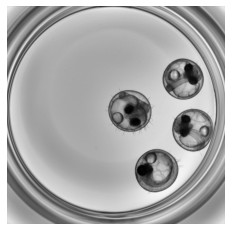

In [3]:
URL = r"https://zenodo.org/record/2650147/files/WE00049---E001--PO01--LO001--CO6--00000000_00.01.00_00.16.00%2C000.jpg"
image = io.imread(URL)
plt.axis("off")
plt.imshow(image, cmap="gray")

Let's crop one embryo to use as a template

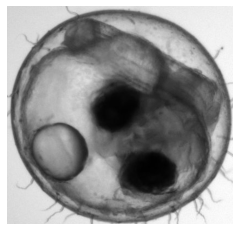

In [4]:
temp0 = image[784:784+400, 946:946+414] # with well 49 
plt.axis("off")
plt.imshow(temp0, cmap="gray")

We can now call `matchTemplates` with this single template image 

In [5]:
# 1st format the template into a list of tuple (label, templateImage)
listTemplates = [temp0]
listLabels    = ["temp0"]

# Then call the function matchTemplates (here a single template)
listDetections = matchTemplates(image, 
                                listTemplates,
                                listLabels,
                                nObjects=4,
                                score_threshold=0.4, 
                                maxOverlap=0.3)

We know in this particular experience the number of object in each image, we can thus set `N_objects=4`.  

Then because the eggs are sometimes touching each others, the rectangular predicted locations might slightly overlap between the different eggs.  
In the same time we dont want to have 2 bounding boxes that match the same egg.  
That's why we set `maxOverlap=0.25` meaning that the ratio between the intersection and union areas between 2 bounding boxes is allowed to be a maximum of 25%.    

Let's have a look at `listDetections`...

In [6]:
print("Found {} hits".format( len(listDetections) ) )
listDetections

Found 4 hits


[(BoundingBox, score:1.00, xyxy:(946, 784, 1359, 1183), index:0, temp0),
 (BoundingBox, score:0.51, xyxy:(1398, 889, 1811, 1288), index:0, temp0),
 (BoundingBox, score:0.47, xyxy:(1438, 481, 1851, 880), index:0, temp0),
 (BoundingBox, score:0.46, xyxy:(1064, 1238, 1477, 1637), index:0, temp0)]

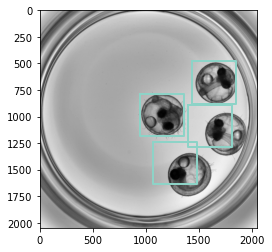

In [7]:
plotDetections(image, listDetections)

2 embryos were correctly detected and 2 are included in the bounding box but not completely included.  
This is due to the fact that the template matching matches intensity patterns, ie it will properly find objects that have the same orientation and perspective as in the template.  
To improve the precision of localisation, one can provide more templates (other perspectives...) to search.  

The additional templates can be generated by rotation or flipping (mirroring) of the initial template.  
This is a bit like doing data-augmentation with the template.  

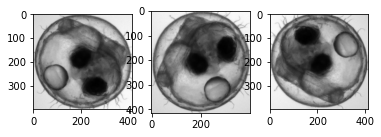

In [8]:
## Perform rotation of the initial template
listTemplates = [temp0]
listLabels    = ["Temp0"]

# Initialise figure
f, axarr = plt.subplots(1,3)
axarr[0].imshow(temp0, cmap="gray")

for i,angle in enumerate([90,180]):
    rotated = np.rot90(temp0, k=i+1) # NB: np.rotate not good here, turns into float!
    listTemplates.append(rotated)
    listLabels.append(str(angle))
    axarr[i+1].imshow(rotated, cmap="gray")
    
    # We could also do some flipping with np.fliplr, flipud

We now have 3 templates in total.  
We can search each of them and still return the 4 best matches.

In [9]:
listDetections = matchTemplates(image, 
                                listTemplates,
                                listLabels,
                                nObjects=4, 
                                score_threshold=0.4, 
                                maxOverlap=0.3)

listDetections

[(BoundingBox, score:1.00, xyxy:(946, 784, 1359, 1183), index:0, Temp0),
 (BoundingBox, score:0.59, xyxy:(1525, 968, 1938, 1367), index:2, 180),
 (BoundingBox, score:0.55, xyxy:(1173, 1354, 1586, 1753), index:2, 180),
 (BoundingBox, score:0.54, xyxy:(1459, 474, 1858, 887), index:1, 90)]

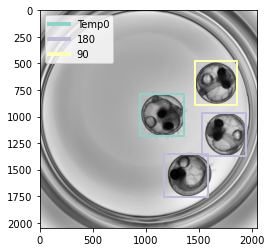

In [11]:
plotDetections(image, listDetections, showLegend=True)

As you can see, the accuracy of the localisation has improved and indeed for those 4 new hits, 3 of them are from rotated versions of the template.

Et voila !  
Using several templates can be used to increase the chance to catch your object if it appears with different perspectives, or to perform classification of the detections using different templates as "classes".  
However, the more templates the longer the computation time.